# IEQ and Survey Response Analysis
Exploring the relationship between the categorical survey responses from the EMA and the IEQ measurements from the Beacon

In [3]:
import warnings
warnings.filterwarnings('ignore')

# IEQ Prior to Mood Reports
We want to know if the IEQ affected participants' mood scores

In [4]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats

# Data Import
We have two datasets to import:

## EMAs Completed at Home
Intersection between GPS coordinates, home address, and the completion of the EMAs.

In [32]:
ema = pd.read_csv("../data/processed/beiwe-ema_at_home_v2-ux_s20.csv",index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
ema.head()

,beiwe,content,stress,lonely,sad,energy,redcap,beacon,time_at_home
timestamp,,,,,,,,,
2020-05-15 09:21:05,mm69prai,1.0,0.0,1.0,1.0,1.0,62,13.0,10412.0
2020-05-15 09:25:04,vr9j5rry,2.0,0.0,0.0,0.0,3.0,34,25.0,29405.0
2020-05-15 12:02:43,kyj367pi,2.0,0.0,1.0,0.0,2.0,10,1.0,3774.0
2020-05-15 12:59:31,lkkjddam,1.0,1.0,2.0,1.0,2.0,12,21.0,5536.0
2020-05-15 17:28:54,9jtzsuu8,2.0,1.0,0.0,0.0,2.0,36,15.0,31643.0


## IEQ Data

In [9]:
ieq = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
ieq.drop(["beacon","redcap","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2","lux","co"],axis=1,inplace=True)
ieq.head()

,tvoc,co2,pm2p5_mass,temperature_c,rh,beiwe,fitbit
timestamp,,,,,,,
2020-06-08 13:00:00,59.283485,NaN,24.767709,16.244700,46.586667,kyj367pi,24.0
2020-06-08 13:02:00,59.501238,NaN,25.379307,16.257887,46.581250,kyj367pi,24.0
2020-06-08 13:04:00,60.484807,NaN,24.874103,16.269523,46.597059,kyj367pi,24.0
2020-06-08 13:06:00,61.532057,NaN,24.503767,16.279865,46.619444,kyj367pi,24.0
2020-06-08 13:08:00,62.381287,NaN,24.824221,16.289119,46.639474,kyj367pi,24.0


## Homestay
We have the homestay data now that we can use to corroborate that the participants are home.

In [10]:
home = pd.read_csv("../data/processed/beiwe-homestay-ux_s20.csv",index_col=0)
home.head()

,home.lat,home.long,start,end,nth.stay,beiwe,t
0,30.290428,-97.750645,2020-07-13 20:30:46,2020-07-14 05:08:52,1,i31pt4b4,31086.0
1,30.290428,-97.750645,2020-07-14 05:48:53,2020-07-14 06:40:53,2,i31pt4b4,3120.0
2,30.290428,-97.750645,2020-07-14 07:08:57,2020-07-14 07:39:15,3,i31pt4b4,1818.0
3,30.290428,-97.750645,2020-07-14 08:14:59,2020-07-14 09:32:53,4,i31pt4b4,4674.0
4,30.290428,-97.750645,2020-07-14 20:16:46,2020-07-15 08:36:58,5,i31pt4b4,44412.0


# IEQ Prior to Survey Submission
We use the timestamps for the survey submission and forward a certain interval to check IEQ conditions.

## Typical Times at Home
We can start by inspecting the typical times that participants were at home prior to submitting their survey.

In [50]:
def plot_time_at_home(df,unit="minutes",bins=np.arange(0,35,5)):
    """plots histogram of times spent at home with given unit and bins"""
    fig, ax = plt.subplots()
    if unit == "minutes":
        divisor = 60
    elif unit == "hours":
        divisor = 3600
    else:
        divisor = 1
        unit = "seconds"
        
    ax.hist(ema["time_at_home"]/divisor,bins=bins,edgecolor="black",color="grey")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

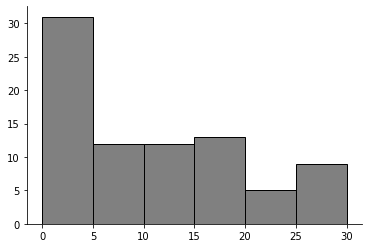

In [51]:
plot_time_at_home(ema)

## Getting IEQ Summary Stats Prior to Submission

In [98]:
def get_ieq_measurements(ieq, ema, window=10):
    """
    Summarizes IEQ measurements for a given period prior to submission of the EMA
    
    Inputs:
    - ieq: dataframe of IEQ data for a given participant
    - ema: dataframe of EMA submission for a given participant
    - window: integer specifying the number of minutes to look ahead. If True, then uses the time prior to submission.
    
    Returns dataframe with EMA scores and summarized IEQ parameters (mean and delta)
    """
    # ensuring timestamp is index of ema
    try:
        ema.set_index("timestamp",inplace=True)
    except KeyError:
        # assuming "timestamp" is the index
        pass
    ema_and_ieq = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        ieq_pt = ieq[ieq["beiwe"] == pt]
        ema_pt = ema[ema["beiwe"] == pt]
        ieq_pt.drop("beiwe",axis=1,inplace=True)
        ieq_prior_mean = pd.DataFrame()
        ieq_prior_delta = pd.DataFrame()
        for t in ema_pt.index:
            if window == True:
                try:
                    t_at_home = ema_pt.loc[t,"time_at_home"]
                    if t_at_home > 500:
                        s = t - timedelta(seconds=t_at_home)
                    else:
                        s = t
                except KeyError as e:
                    print(e)
                    return
            else:
                s = t - timedelta(minutes=window)
            ieq_prior = ieq_pt[s:t]
            ieq_prior_mean = pd.concat([ieq_prior_mean,ieq_prior.mean(axis=0)],axis=1)
            ieq_prior_delta = pd.concat([ieq_prior_delta,ieq_prior.max(axis=0) - ieq_prior.min(axis=0)],axis=1)

        ieq_prior_mean = ieq_prior_mean.T
        ieq_prior_mean.columns  = [col+"_mean" for col in ieq_prior_mean.columns]

        ieq_prior_delta = ieq_prior_delta.T
        ieq_prior_delta.columns  = [col+"_delta" for col in ieq_prior_delta.columns]

        ema_ieq_pt = pd.concat([ema_pt.reset_index(),ieq_prior_mean.reset_index(drop=True),ieq_prior_delta.reset_index(drop=True)],axis=1)
        ema_and_ieq = ema_and_ieq.append(ema_ieq_pt)

    return ema_and_ieq

In [99]:
ema_ieq = get_ieq_measurements(ieq,ema,window=True)

In [100]:
print("Number of Participants:", len(ema_ieq.dropna()["beiwe"].unique()))

Number of Participants: 21


# Analysis
The following is the general analysis that follows:
1. Difference in IEQ distributions for low and high mood scores
2. Time dependence on mood
2. Contingency tables and associated metrics for low and high IEQ and mood parameters
3. Relationship between mood and ventilation rate

## IEQ Distributions for Low and High Mood Scores
The first part of the analysis is examining the difference in IEQ distributions when participants moods are low (0 or 1) or high (1 or 2). 

### Initial Impressions
By using stripplots we can see if there are any noticeable tendencies

In [88]:
def plot_strips(ieq_param="co2",summary_stat="mean"):
    """"""
    fig, axes = plt.subplots(1,4,figsize=(16,4),sharey=True,gridspec_kw={"wspace":0.05})
    for mood, ax in zip(["content","stress","lonely","sad"],axes.flat):
        sns.stripplot(x=mood,y=f"{ieq_param}_{summary_stat}",data=ema_ieq,
                      alpha=0.5,ax=ax)
        ax.set_xlabel(mood.title())
        ax.set_ylabel("")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
    axes[0].set_ylabel(f"{summary_stat.title()} {visualize.get_pollutant_label(ieq_param)} ({visualize.get_pollutant_units(ieq_param)})")
    
    plt.show()
    plt.close()
        

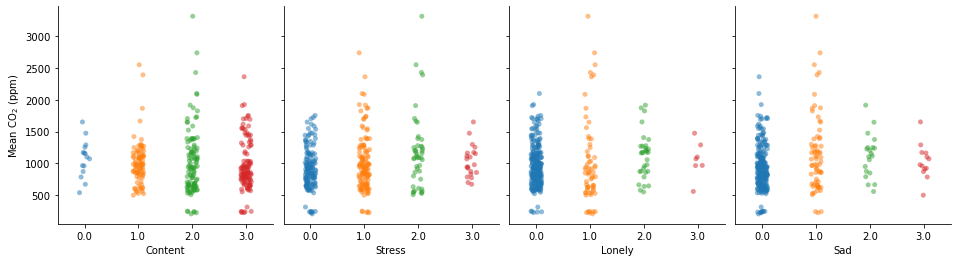

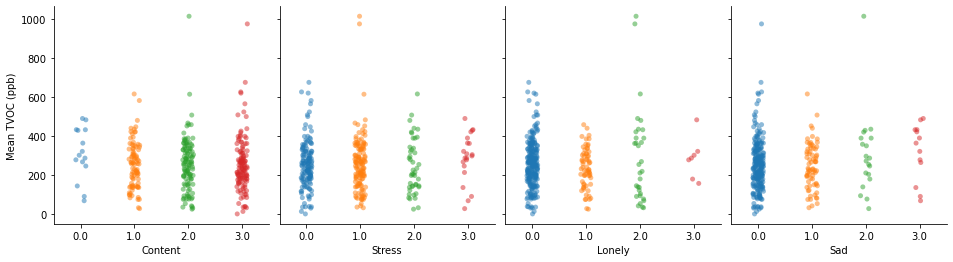

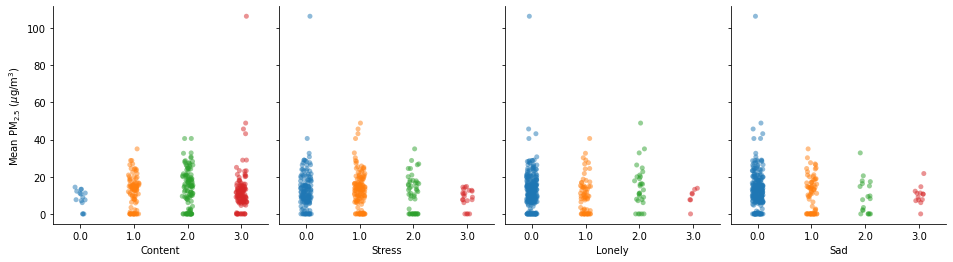

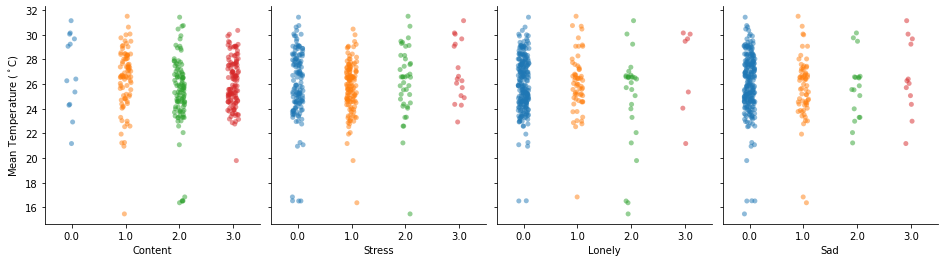

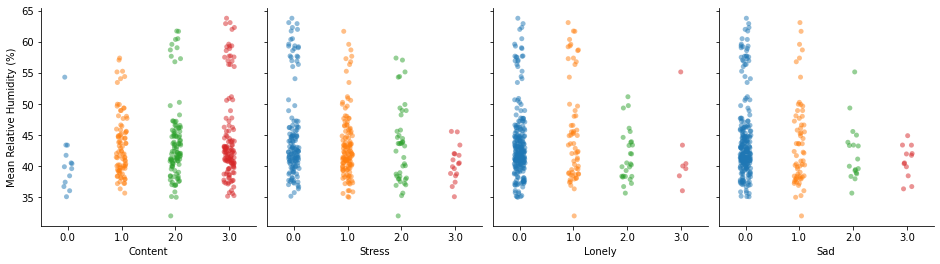

In [89]:
for ieq_param in ["co2","tvoc","pm2p5_mass","temperature_c","rh"]:
    plot_strips(ieq_param=ieq_param)

### Binarizing EMA Scores
The mood scores are on a 4-point scale, but we can change each to a binary variable since many of the _extreme_ scores have fewer observations. 

In [90]:
ema_bi_ieq = ema_ieq.copy()
for mood in ["content","stress","lonely","sad"]:
    ema_bi_ieq[mood] = ["low" if score < 2 else "high" for score in ema_bi_ieq[mood]]

### Discontent Over Content
Three of the four mood scores are negative i.e. for a good score, you want to rate your mood low whereas the `content` score is the opposite. We can get around this by defining a `discontent` score which will simply be the opposite of `content`.

In [91]:
ema_bi_ieq["discontent"] = ["low" if score == "high" else "high" for score in ema_bi_ieq["content"]]

### Plotting Aggregate Violins and P-Values
Since we had the code to visualize and calculate p-values, we pull that in here and visualize the distributions in addition to providing the p-values.

In [92]:
def plot_mood_violin_per_ieq(df_in,ieq_params=["co2","tvoc","pm2p5_mass","temperature_c","rh"],summary_stat="mean",moods=["discontent","stress","lonely","sad"]):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    # creating dictionary to store p-values
    ttest_results = {}
    fig, axes = plt.subplots(len(ieq_params),1,figsize=(4*len(moods),4*len(ieq_params)),sharex=True)
    for ieq_param, title, ax in zip(ieq_params,["a","b","c","d","e","f"],axes.flat):
        df_expanded = df_in.melt(id_vars=[c for c in df_in.columns if c.endswith(summary_stat)],value_vars=moods)
        sns.violinplot(x="variable",y=f"{ieq_param}_{summary_stat}",hue="value",data=df_expanded,
                       split=True,inner=None,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([mood.title() for mood in moods],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(ieq_param),fontsize=label_fs)
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        if ieq_param == "rh":
            ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Mood Score")
        else:
            ax.get_legend().remove()
        
        pvals = pd.DataFrame()
        for mood in moods:
            df = df_expanded[df_expanded["variable"] == mood]
            low_vals = df[df["value"] == "low"]
            high_vals = df[df["value"] == "high"]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[f"{ieq_param}_{summary_stat}"],high_vals[f"{ieq_param}_{summary_stat}"], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"mood":[mood],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[f"{ieq_param}_{summary_stat}"])],"mean_high":np.nanmean(high_vals[f"{ieq_param}_{summary_stat}"]),"p_val":[p]}))

        ttest_results[ieq_param] = pvals.set_index("mood")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[ieq_param]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
        
    plt.show()
    plt.close()
    
    return ttest_results

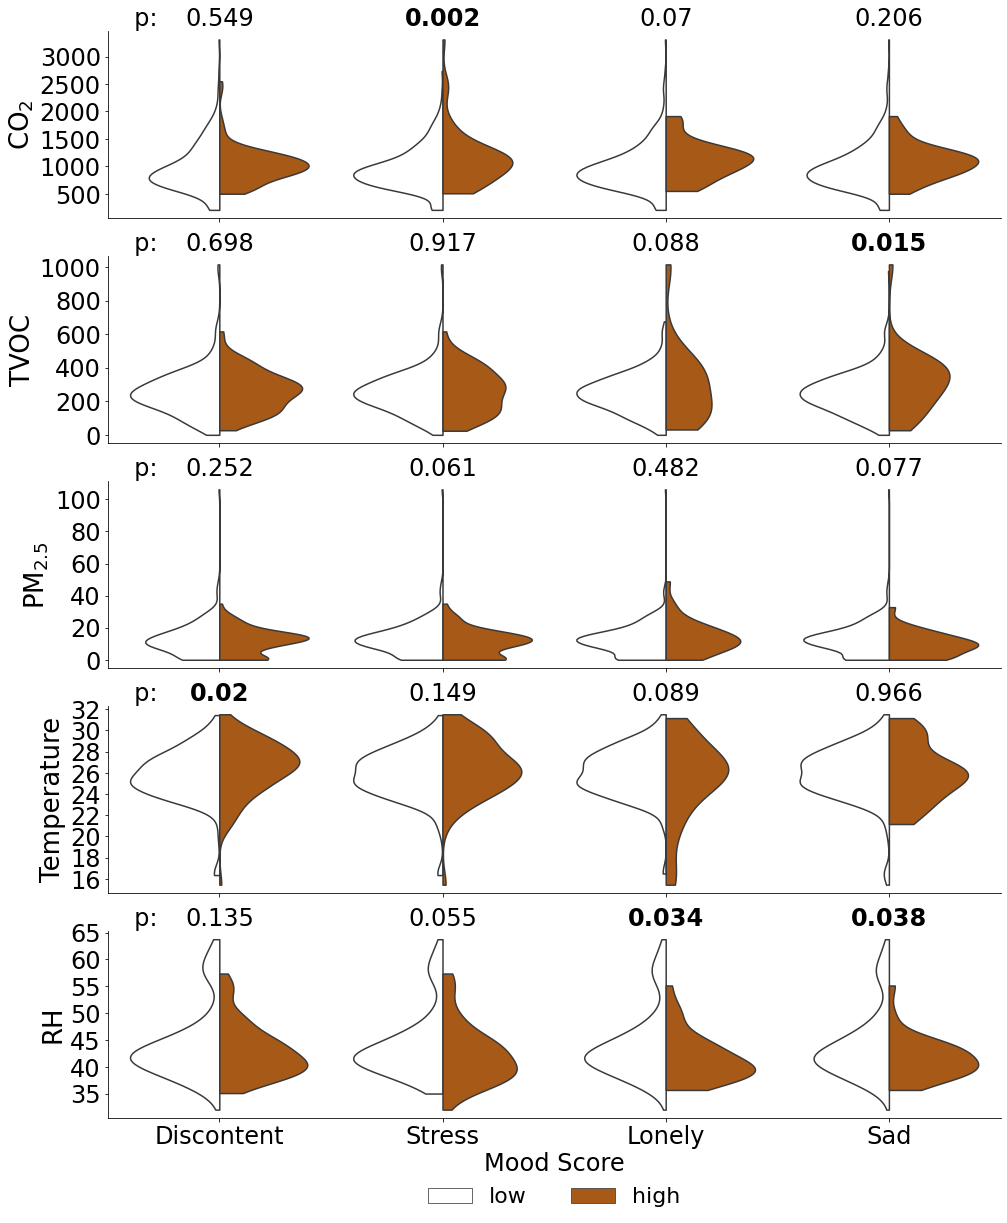

In [97]:
ieq_dist_ttest = plot_mood_violin_per_ieq(ema_bi_ieq,summary_stat="mean")

## Time Dependence on Exposure at Home on Mood
With the amount of time at home, we can use this time to see if the mood scores are influenced by the time the participant is exposed to the pollution at home.

### Time at Home Only
We can start by looking at the time at home in a vacuum without considering IEQ's effect at all.

In [102]:
ema.head()

,beiwe,content,stress,lonely,sad,energy,redcap,beacon,time_at_home
timestamp,,,,,,,,,
2020-05-15 09:21:05,mm69prai,1.0,0.0,1.0,1.0,1.0,62,13.0,10412.0
2020-05-15 09:25:04,vr9j5rry,2.0,0.0,0.0,0.0,3.0,34,25.0,29405.0
2020-05-15 12:02:43,kyj367pi,2.0,0.0,1.0,0.0,2.0,10,1.0,3774.0
2020-05-15 12:59:31,lkkjddam,1.0,1.0,2.0,1.0,2.0,12,21.0,5536.0
2020-05-15 17:28:54,9jtzsuu8,2.0,1.0,0.0,0.0,2.0,36,15.0,31643.0


In [125]:
def plot_mood_on_time(df,mood="content"):
    _, ax = plt.subplots(figsize=(12,6))
    df["minutes_at_home"] = df["time_at_home"] / 60
    for cutoff in np.arange(15,360,15):
        ema_by_cutoff = df[df["minutes_at_home"] <= cutoff]
        avg = ema_by_cutoff.mean(axis=0)
        ax.scatter(cutoff,avg[mood],s=len(ema_by_cutoff),color="black")


    ax.set_ylim([0,3])
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

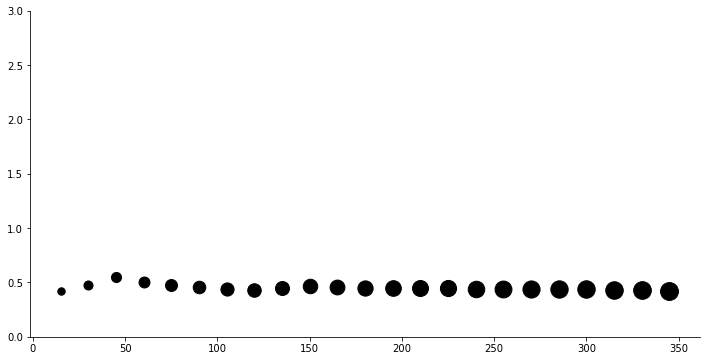

In [126]:
plot_mood_on_time(ema,"sad")

<div class="alert alert-block alert-warning">

There does not seem to be a major relationship between the mood and the amount of time spent at home.
    
</div>

## Contigency Tables
With the contigency tables, we address any participant bias that might have slipped into the previous analysis because of one participant having better or worse IAQ conditions.

### Binarizing IAQ Based on Participant-Specific Values
Rather than consider IAQ thresholds which provide a host of their own issues (participant adaptation, measurements all above or below threshold, etc.), we binarize IAQ as good or bad based on the mean concentration the participant experienced during the study period. 

In [20]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return "high"
    else:
        return "low"

In [21]:
def get_binary_ieq(df,raw_ieq,pollutants=["co2","tvoc","pm2p5_mass","temperature_c","rh"]):
    """
    Gets the binary encoding of the vars in pollutants for each participant
    
    Inputs:
        - df: dataframe with mean pollutant concentrations
        - raw_ieq: dataframe of the unaltered ieq data from the entire deployment
        - pollutants: list of strings corresponding to the IEQ parameters of interest - must have corresponding columns in the other two dataframes
    """
    df_bi = pd.DataFrame()
    for pt in df["beiwe"].unique():
        df_pt = df[df["beiwe"] == pt]
        ieq_pt = raw_ieq[raw_ieq["beiwe"] == pt]
        for pollutant in pollutants:
            try:
                mean_night = np.nanmean(ieq_pt[f"{pollutant}"])
            except KeyError as e:
                print(f"Exiting: {e} not in the raw IEQ data")
                return
            
            df_pt[f"{pollutant}_binary"] = df_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_mean"],mean_night), axis="columns")

        df_bi = df_bi.append(df_pt)

    return df_bi

In [22]:
ema_bi_ieq_bi = get_binary_ieq(ema_bi_ieq,ieq)

### Contingency Tables
Now with both mood and IEQ binarized, we can create the contigency tables and visualize them. Python even has a built-in function for this: [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html).

See more [here](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

We try two metrics on the contigency table:
1. Matthews Correlation Coefficient (also called the Phi Coefficient)
2. Cramer's V

Turns out these metrics are essentially the same with Cramer's V taking the absolute value of the Matthews Coefficient.

In [23]:
from sklearn.metrics import matthews_corrcoef
import scipy.stats as stats

In [24]:
def calculate_cramers_v(ct):
    """returns Cramers V from the given contingency table"""
    #create 2x2 table
    data = ct.values

    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data)
    minDim = min(data.shape)-1

    #calculate Cramer's V 
    V = np.sqrt((X2/n) / minDim)

    #display Cramer's V
    return V

Getting Contigency Tables and calculating scores.

In [25]:
for mood in ["discontent","sad","lonely","stress"]:
    print(mood.upper())
    #for ieq_param in ["co2","tvoc","pm2p5_mass","temperature_c","rh"]:
    ct = pd.crosstab(columns=ema_bi_ieq_bi[mood],index=[ema_bi_ieq_bi[f"co2_binary"],ema_bi_ieq_bi[f"temperature_c_binary"],ema_bi_ieq_bi[f"pm2p5_mass_binary"],ema_bi_ieq_bi[f"rh_binary"],ema_bi_ieq_bi[f"tvoc_binary"]])
    #print(matthews_corrcoef(ema_bi_ieq_bi[mood],ema_bi_ieq_bi[f"{ieq_param}_binary"]))
    print(round(calculate_cramers_v(ct),3))#,"\t-\t",ieq_param)
    #print(ct)
    print()

DISCONTENT
0.278

SAD
0.221

LONELY
0.202

STRESS
0.25



## Ventilation and Mood
We scatter the summarized mood scores over the study period versus the average ventilation rate determined from the carbon dioxide concentrations.

In [26]:
ach = pd.read_csv("../data/processed/beacon-ventilation_from_ss.csv")

In [27]:
def scatter_ach_and_mood(ach, mood, summary_stat="mean"):
    """"""
    # how to summarize the mood scores
    if summary_stat == "median":
        mood_pt = mood.groupby("beiwe").median()
    elif summary_stat == "std":
        mood_pt = mood.groupby("beiwe").std()
    else:
        mood_pt = mood.groupby("beiwe").mean()
        
    # always averaging the ventilation rates
    ach_pt = ach.groupby("beiwe").std()["ach"]
    
    # merging
    merged = mood_pt[["content","stress","lonely","sad"]].merge(right=ach_pt,left_index=True,right_index=True)
    
    # scattering
    fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
    for m, ax in zip(["content","sad","lonely","stress"],axes.flat):
        ax.scatter(merged["ach"],merged[m],s=50,color="black")
        # x-axis
        ax.set_xlabel("Ventilation Rate (h$^{-1}$)")
        # remainder
        ax.set_title(m.title())
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
    # y-axis
    axes[0].set_ylabel(f"Mood Scored ({summary_stat})")
    plt.show()
    plt.close()
    
    return merged

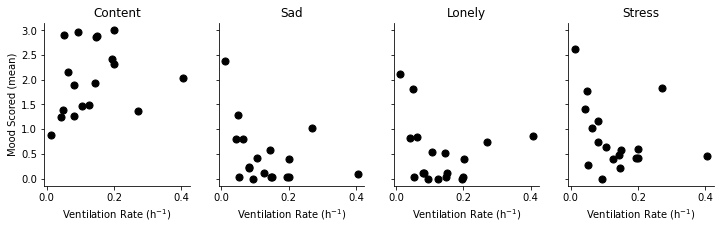

,content,stress,lonely,sad,ach
beiwe,,,,,
745vq78e,2.896552,0.275862,0.034483,0.034483,0.053160
9jtzsuu8,1.480000,0.400000,0.000000,0.120000,0.126161
9xmhtq74,2.970588,0.000000,0.000000,0.000000,0.093973
awa8uces,1.257143,1.171429,0.114286,0.228571,0.081519
e73a1pd5,0.875000,2.625000,2.125000,2.375000,0.012665
i31pt4b4,2.166667,1.033333,0.833333,0.800000,0.063641
idbkjh8u,1.470588,0.647059,0.529412,0.411765,0.106068
kyj367pi,2.045455,0.454545,0.863636,0.090909,0.405498
lkkjddam,1.366667,1.833333,0.733333,1.033333,0.270075


In [28]:
scatter_ach_and_mood(ach,ema,summary_stat="mean")